In [88]:
from skimage.morphology import thin
import sys
from pathlib import Path
sys.path.append('..')
from PIL import Image
import numpy as np
from skimage import filters
from skimage import io, color
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import pyramid_gaussian
from skimage import morphology
from skimage import transform
import math
from scipy.ndimage import distance_transform_edt
import pandas as pd


folder = './images_IOSTAR'

list_of_gt = Path(folder).rglob('GT_*.png')
list_of_files = Path(folder).rglob('star*.jpg')
#read files and convert them to numpy arrays
images_gt = []
for file in list_of_gt:
    images_gt.append(np.asarray(Image.open(file)).astype(np.uint8))

images = []
for file in list_of_files:
    images.append(np.asarray(Image.open(file)).astype(np.uint8))

In [89]:
def get_mask(img):
    '''Mask selectionnant seulement les pixels dans le cercle inscrit ci-dessous.'''
    nrows, ncols = img.shape
    row, col = np.ogrid[:nrows, :ncols]

    #On ne considere que les pixels dans le disque inscrit 
    img_mask = (np.ones(img.shape)).astype(np.bool_)
    invalid_pixels = ((row - nrows/2)**2 + (col - ncols/2)**2 > ((nrows - 5)/ 2)**2)
    
    img_mask[invalid_pixels] = 0
    return img_mask

In [90]:
def normalize_min_max(img, mask):
    # Find the minimum and maximum values in the masked image
    masked_image = img * mask
    min_val = np.min(masked_image[np.nonzero(mask)])
    max_val = np.max(masked_image)

    # Normalize the masked region
    normalized_masked_image = (masked_image - min_val) / (max_val - min_val)

    # Reapply the normalized values to the original image
    normalized_image = img.copy()
    normalized_image[mask == 1] = normalized_masked_image[mask == 1] * 255
    return normalized_image

In [91]:
def plot_pyramid(pyramid):
    fig, ax = plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        ax[i].imshow(pyramid[i]['lapl'], cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'Layer {i}')
    plt.show()

In [92]:
def gaussian_pyramid(image, octave, sigma=1.0, order = 3):
    pyramid = []
    h,w = image.shape
    layers = pyramid_gaussian(image, sigma=sigma, max_layer=octave, downscale=2)


    for layer in layers:
        newI = layer
        mask = get_mask(newI)
        laplacian = filters.laplace(layer, mask=mask)
        laplacian = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)
        
        pyramid.append({'I':newI, 'lapl': laplacian})

    return pyramid

# Analyse exploratoire

## Epaisseur des vaisseaux

#### Analyse des vérités terrain et des squelettes 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

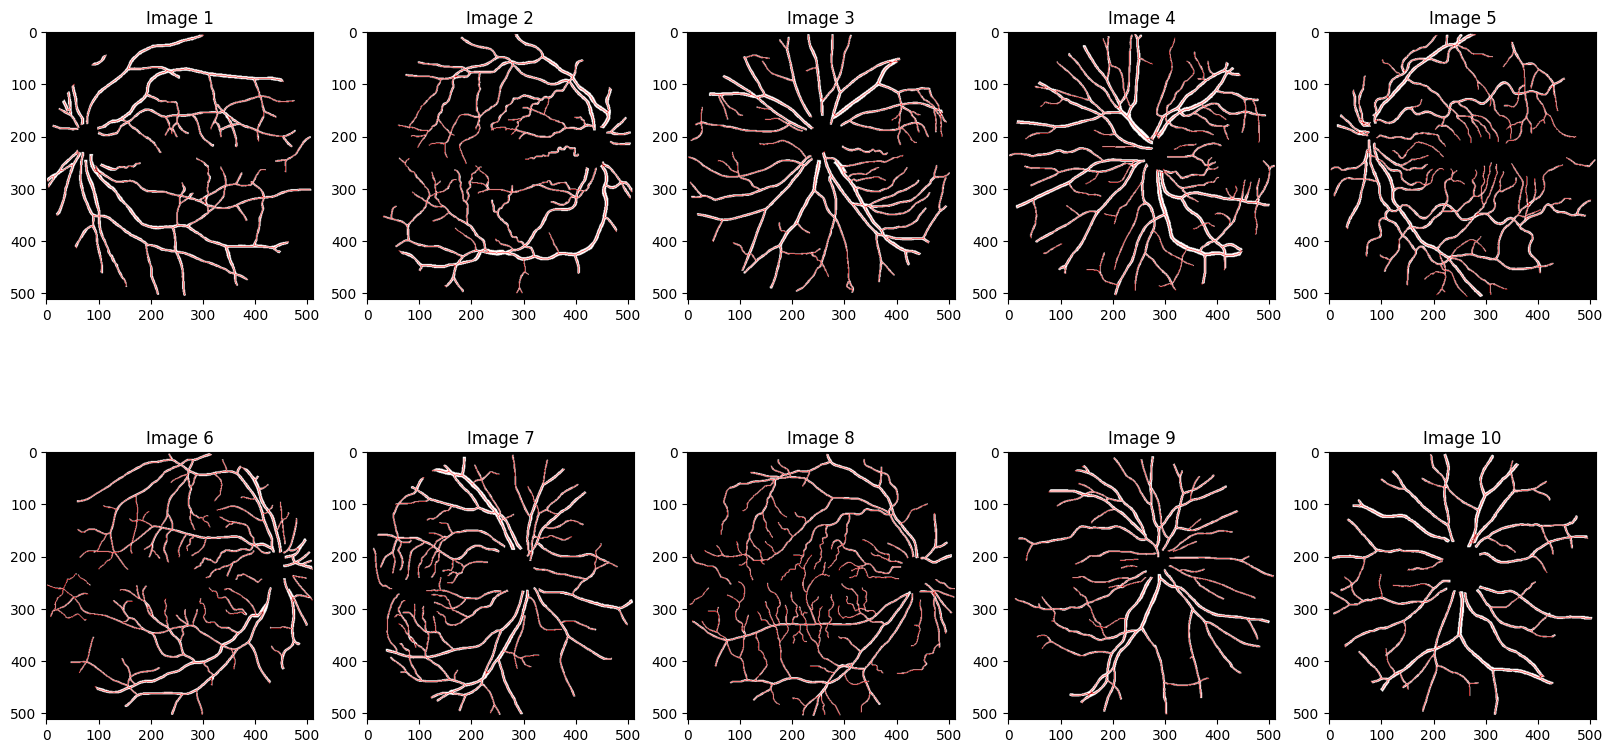

In [93]:
plt.figure(figsize=(20, 10))
for i in range(len(images)):

    GT_skel = thin(images_gt[i], max_num_iter=15)

    img_GT_rgb = np.dstack([images_gt[i]] * 3) * 255
    # Create a copy for overlay
    overlay = img_GT_rgb.copy()
    overlay[GT_skel, 0], overlay[GT_skel,
                                 1], overlay[GT_skel, 2] = 255, 0, 0  # Set red color

    rows = 2
    cols = math.ceil(len(images) / rows)

    plt.subplot(rows, cols, i+1)
    plt.imshow(overlay)
    plt.title(f'Image {i+1}')
plt.tight_layout

#### Calcul des épaisseurs

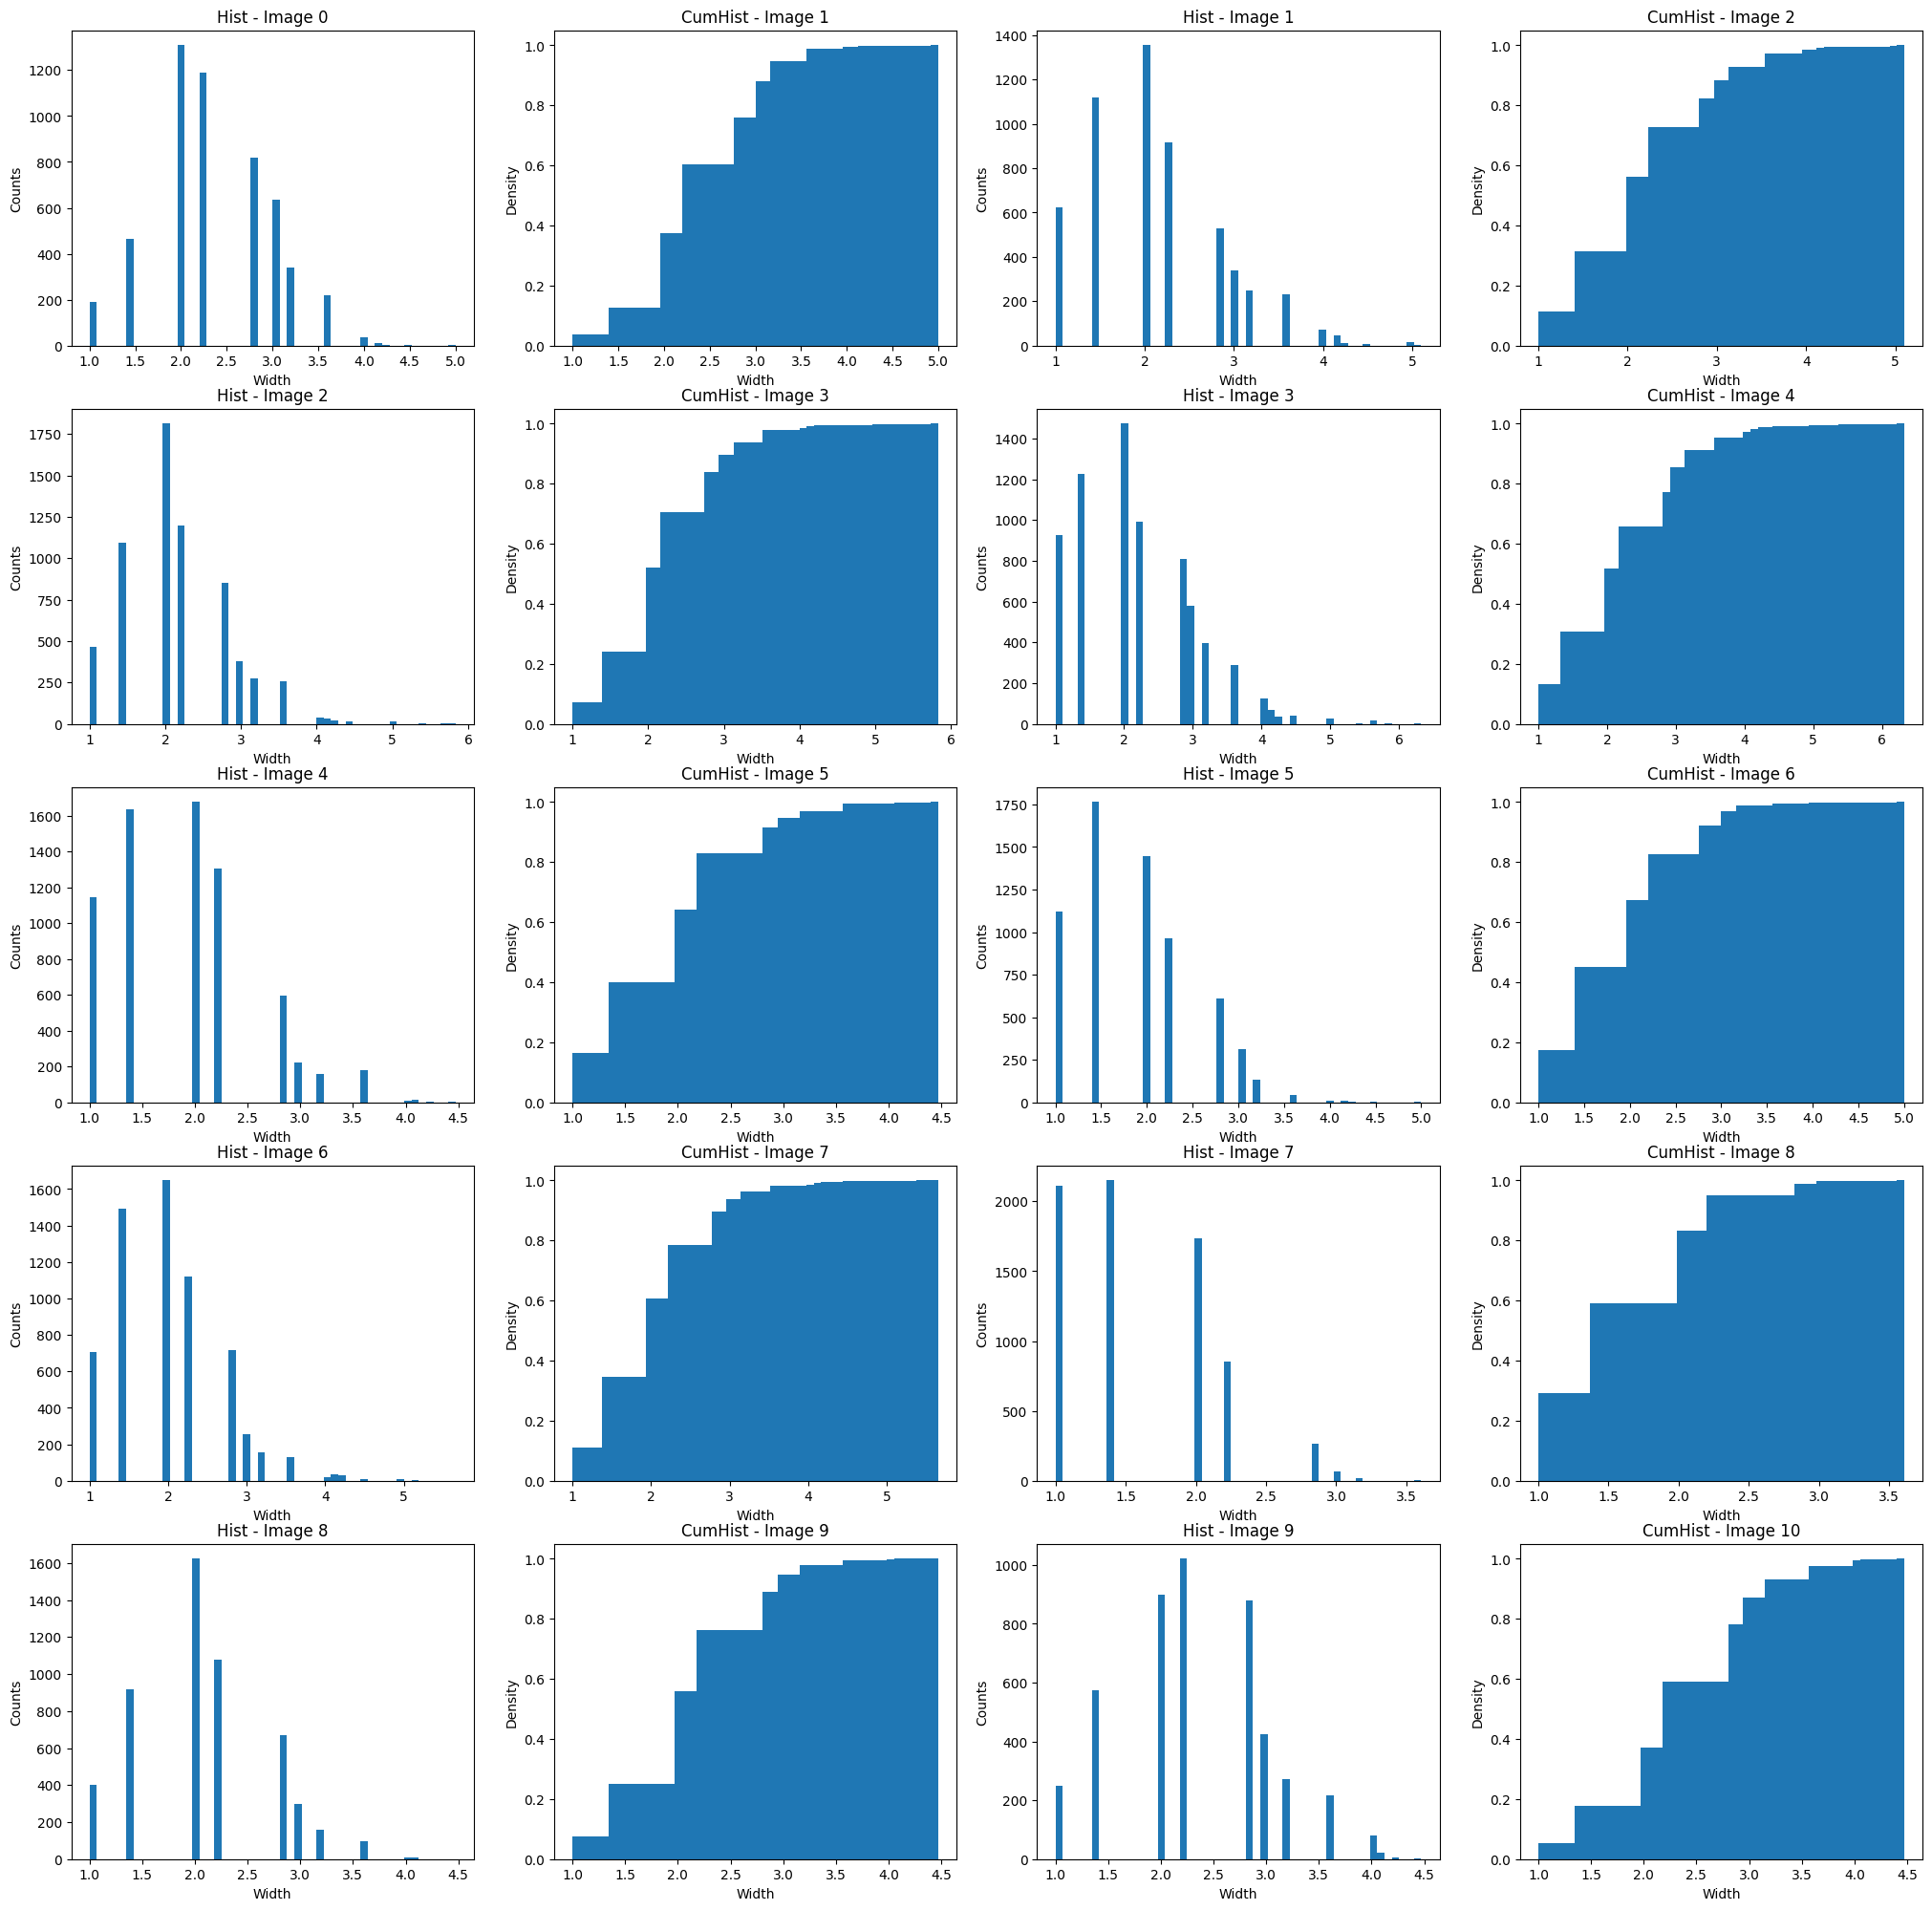

In [94]:
plt.figure(figsize=(25, 30))
cols = 4
rows = math.ceil(len(images) / cols) * 2

for i in range(len(images)):

   distance = distance_transform_edt(images_gt[i])
   GT_skel = thin(images_gt[i], max_num_iter=15)
   vessel_widths = distance[GT_skel]

   plt.subplot(rows, cols, 2*i+1)
   plt.hist(vessel_widths.flatten(), bins=50)
   plt.title(f'Hist - Image {i}')
   plt.xlabel('Width')
   plt.ylabel('Counts')

   plt.subplot(rows, cols, 2*(i+1))
   plt.hist(vessel_widths.flatten(), bins=50, cumulative=True, density=True)
   plt.title(f'CumHist - Image {i+1}')
   plt.xlabel('Width')
   plt.ylabel('Density')

#### Exemple sur la 1ere image

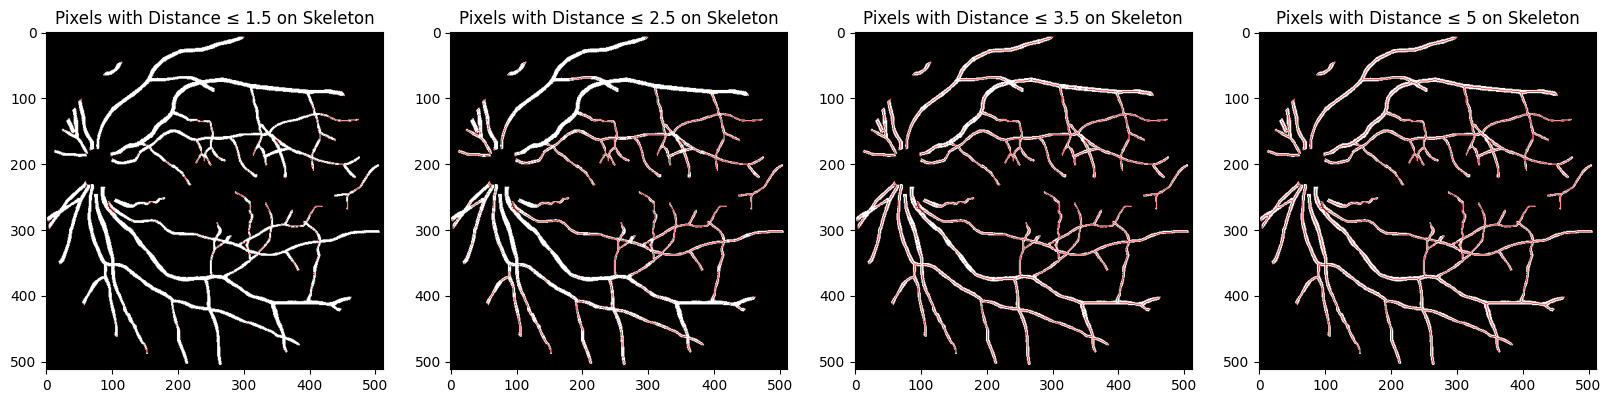

In [95]:
distance = distance_transform_edt(images_gt[0]).astype(np.float32)
GT_skel = thin(images_gt[0], max_num_iter=15)
Dist_Thd = [1.5, 2.5, 3.5, 5]

plt.figure(figsize=(20, 5))
for d_idx, d in enumerate(Dist_Thd, start=1):
   mask_distance_leq = (distance <= d) & GT_skel

   img_GT_rgb = np.stack((images_gt[0], images_gt[0], images_gt[0]),
                         axis=-1).astype(np.uint8) * 255
   img_GT_rgb[mask_distance_leq] = [255, 0, 0]  # Red color

   # Ensure the image to plot is uint8
   img_GT_rgb = img_GT_rgb.astype(np.uint8)

   # Now plot
   plt.subplot(1, len(Dist_Thd), d_idx)
   plt.imshow(img_GT_rgb)
   plt.title(f'Pixels with Distance ≤ {d} on Skeleton')

## Analyse du niveau de gris

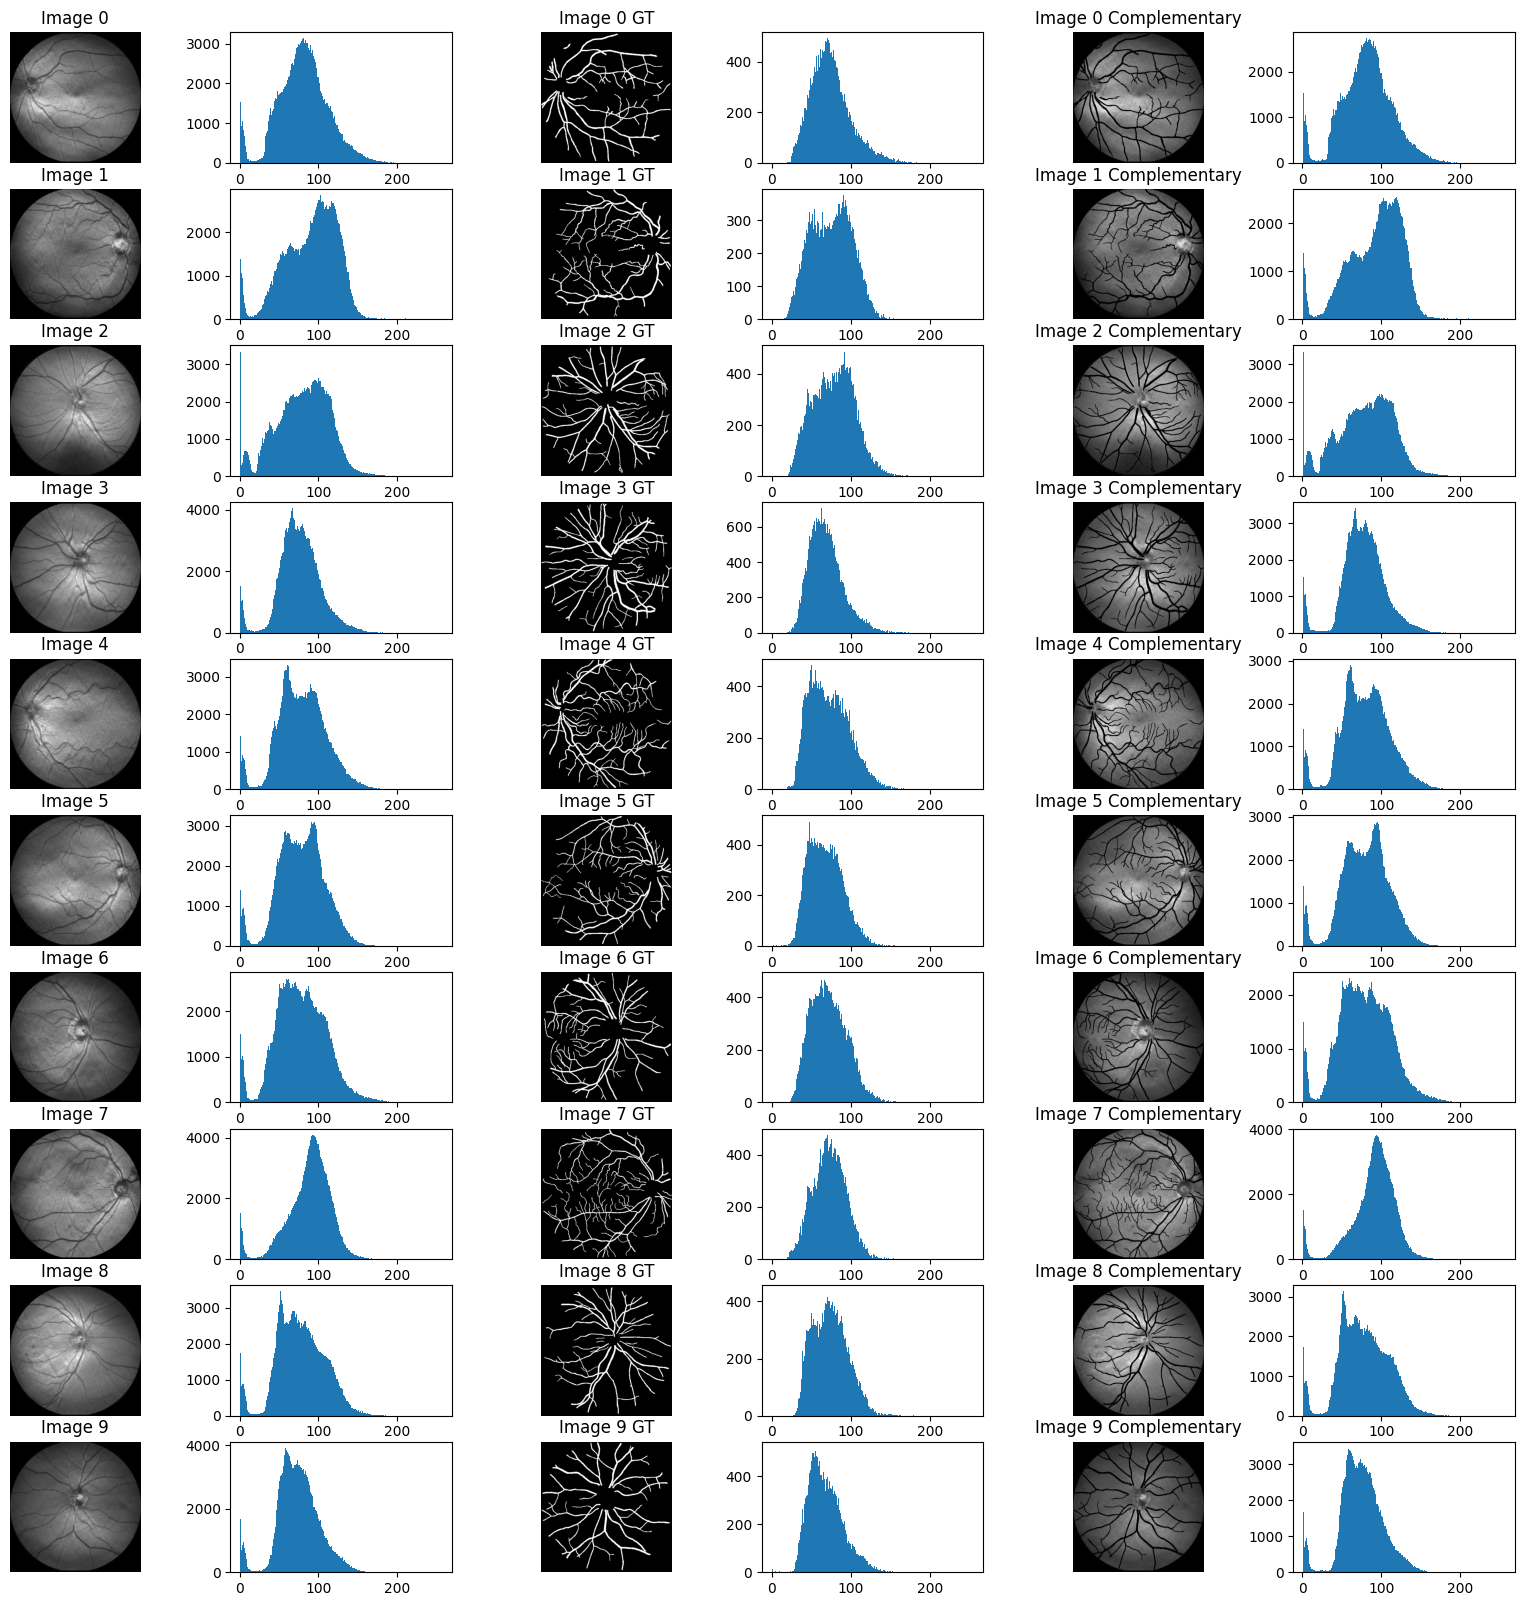

In [96]:
# display images
Min_image_pixels = 256

plt.figure(figsize=(20, 20))

for i in range(len(images)):
    plt.subplot(10, 6, 6*i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i}')

    # plot histogram of the image
    plt.subplot(10, 6, 6*i+2)
    plt.hist(images[i].ravel(), bins=256, range=(
        1, 256))  # J'enlève la valeur 0 car biaise le plot !

    plt.subplot(10, 6, 6*i+3)
    plt.imshow(images_gt[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i} GT')

    # plot histogram of the pixel of the original image that match the mask
    plt.subplot(10, 6, 6*i+4)
    image_pixels = images[i][images_gt[i] > 0]
    plt.hist(image_pixels, bins=256, range=(0, 255))

    # Calculate and display complementary of the mask
    plt.subplot(10, 6, 6*i+5)
    comp_img = np.where(images_gt[i], 0, images[i])
    plt.imshow(comp_img, cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i} Complementary')

    # Plot histogram for the complementary of the mask
    plt.subplot(10, 6, 6*i+6)
    plt.hist(comp_img.ravel(), bins=256, range=(
        1, 256))  # Idem on enlève 0 car trop de points

# Algorithme de séparation des veines du fond occulaire

In [97]:
def my_segmentation(img,sigma=2.3,upscale_factor=7, octave=3, order =3, mS=60, Connect=0, ds=0):
    # Increase image size
    h,w = img.shape
    #Preprocessing
    img = normalize_min_max(img, get_mask(img))
    img = transform.resize(img, (h*upscale_factor, w*upscale_factor), anti_aliasing=True, order=order)

    #feature extraction
    pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)
    laplacian = np.zeros((h*upscale_factor,w*upscale_factor))
    for i in range(len(pyramid)):

        laplacian += pyramid[i]['lapl']
    l_resized = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)

    # segmentation (thresholding)
    thd = filters.threshold_otsu(l_resized)
    binary = l_resized > thd

    out11 = morphology.closing(~binary, morphology.disk(ds))

    out = morphology.remove_small_objects(
        out11, min_size=mS, connectivity=Connect)
    
    return out

In [121]:
def my_evaluate(img, binary, GT):
    from script_tp2 import evaluate
    ACCU, RECALL, img_out_skel, GT_skel = evaluate(binary, GT)
    plt.figure(figsize=(8,3))
    plt.subplot(1,4,1)
    plt.imshow(color.label2rgb(img_out_skel, img, bg_label=-1, alpha=0.5))
    plt.title('Image skeleton')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(GT_skel, cmap='binary')
    plt.title('GT skeleton')
    plt.axis('off')
    #plt.show()

    plt.subplot(1,4,3)
    plt.imshow(GT_skel & ~binary, cmap='binary')
    plt.title('False negative')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(img_out_skel & ~GT, cmap='binary')
    plt.title('False positive')
    plt.axis('off')

    plt.show()

    #print(f'Accuracy: {ACCU}')
    #print(f'Recall: {RECALL}')
    return ACCU, RECALL

In [99]:
def run_eval():
   p_mem, r_mem = [], []
   for i in range(len(images)):
      edge = my_segmentation(images[i])
      p, r = my_evaluate(images[i], edge, images_gt[i])
      p_mem.append(p)
      r_mem.append(r)

   image_ids = [f'Img{i+1}' for i in range(10)]
   results_dict = {image_id: [round(p_mem[i],2), round(r_mem[i],2)]
                   for i, image_id in enumerate(image_ids)}
   
   results_dict['Mean Performance'] = [round(np.mean(p_mem),2), round(np.mean(r_mem),2)]
   results_dict['Std Performance'] = [round(np.std(p_mem),2), round(np.std(r_mem),2)]

   # Create a DataFrame from the dictionary
   results_df = pd.DataFrame(results_dict, index=['Preci', 'Recall'])

   # Transpose the DataFrame to have images as columns and precision/recall as rows

   results_str = results_df.to_string()
   print(results_str)

   #print(f"total precision {np.mean(p_mem)} +/- {np.std(p_mem)}")
   #print(f"total precision {np.mean(r_mem)} +/- {np.std(r_mem)}")


# Choix de la normalisation

In [100]:
def normalize_mean_std(img,mask):
    masked_image = img * mask
    mean = np.mean(masked_image[np.nonzero(mask)])
    std = np.std(masked_image[np.nonzero(mask)])

    normalized_masked_image = (masked_image - mean) / std

    return normalized_masked_image

Text(0.5, 1.0, 'Normalized image with mean and std')

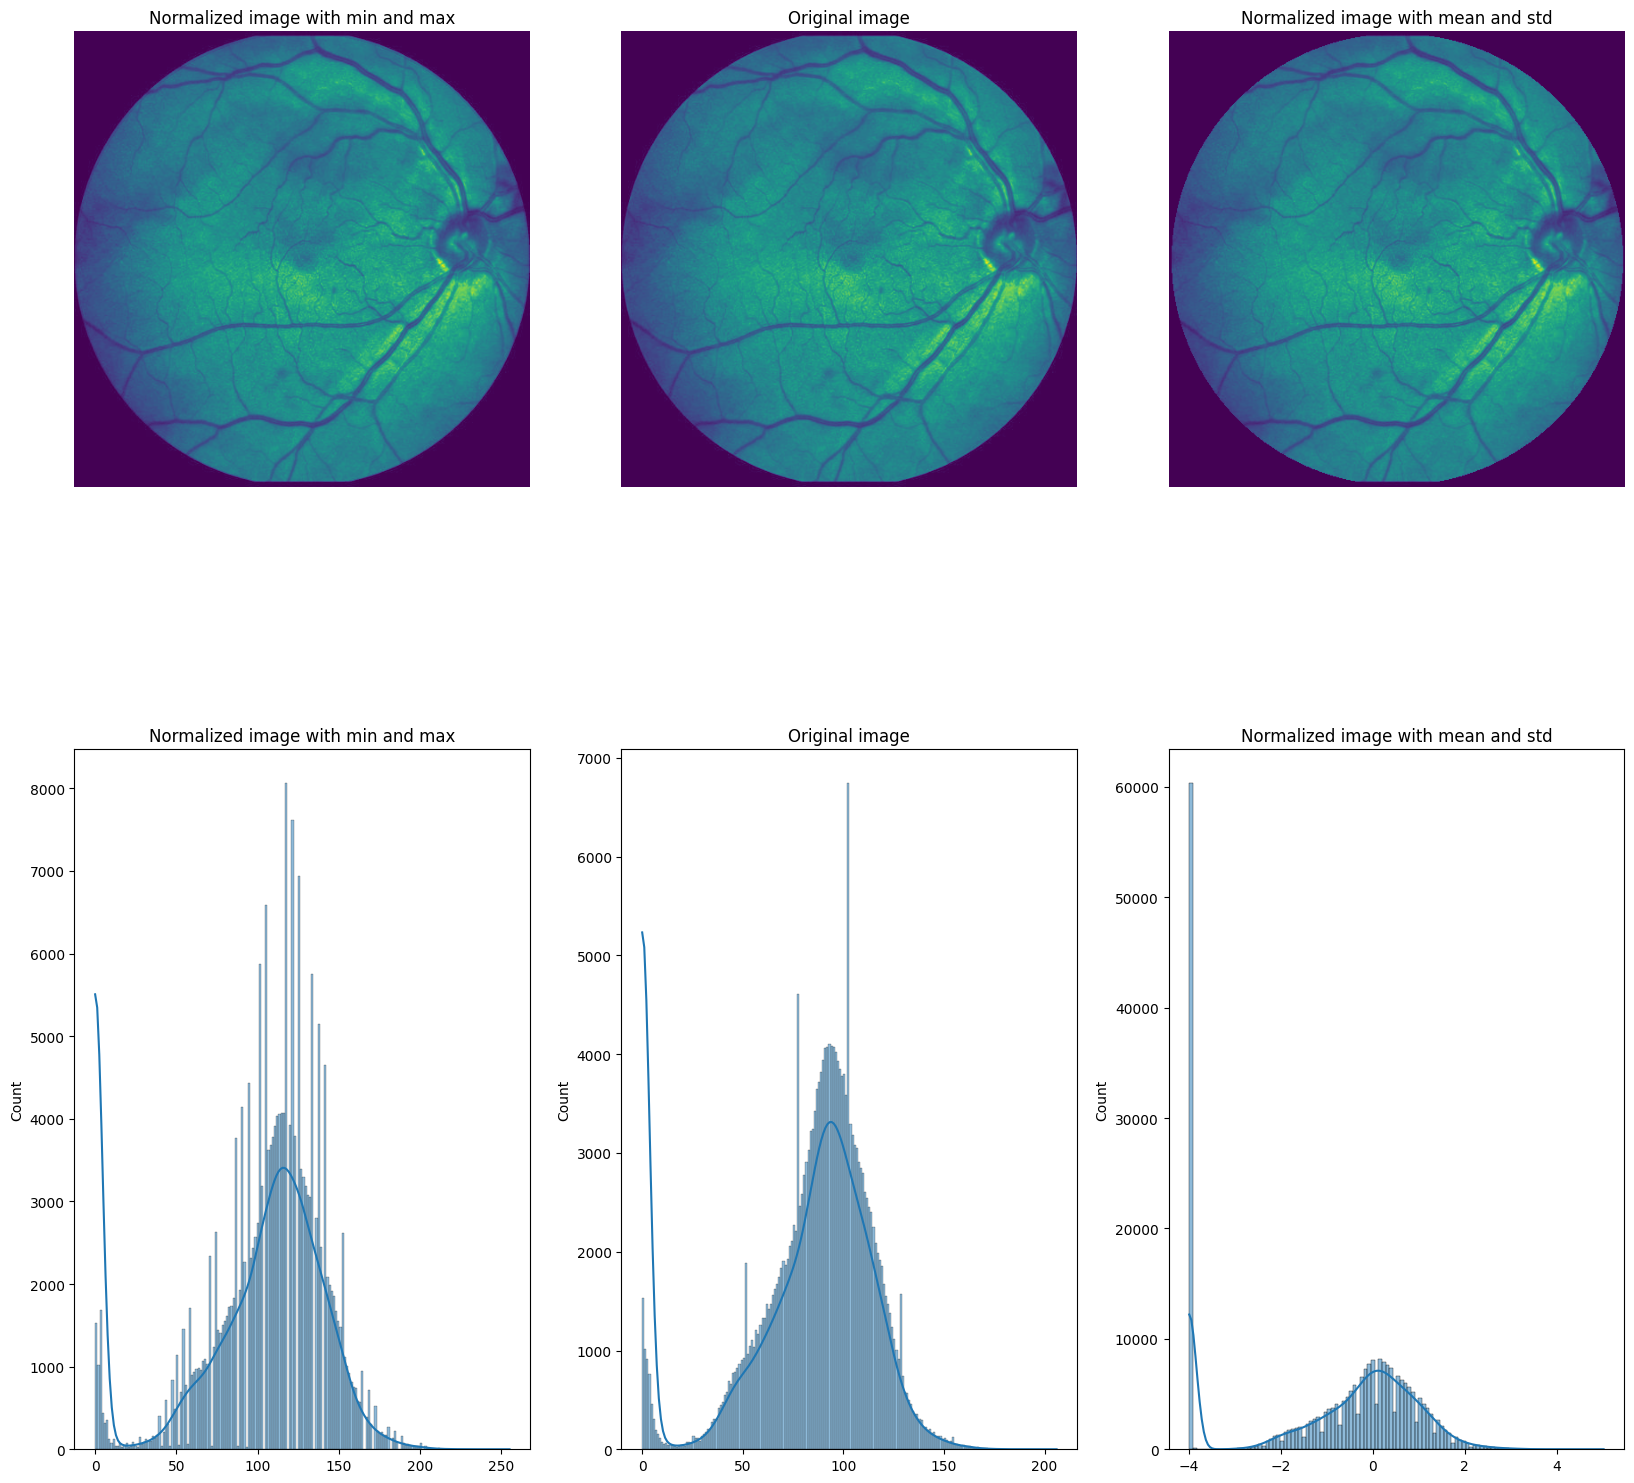

In [101]:
img = images[7]
mask = get_mask(img)
img_n_min_max = normalize_min_max(img, mask)
img_n_mean_std = normalize_mean_std(img, mask)
plt.figure(figsize=(20,20))
plt.subplot(2,3,1)
plt.imshow(img_n_min_max)
plt.axis('off')
plt.title('Normalized image with min and max')


plt.subplot(2,3,2)
plt.imshow(img)
plt.axis('off')
plt.title('Original image')

plt.subplot(2,3,3)
plt.imshow(img_n_mean_std)
plt.axis('off')
plt.title('Normalized image with mean and std')

plt.subplot(2,3,4)
sns.histplot(img_n_min_max.ravel(),binrange=[0.01, np.max(img_n_min_max)], kde=True)
plt.title('Normalized image with min and max')

plt.subplot(2,3,5)
sns.histplot(img.ravel(),binrange=[0.01, np.max(img)], kde=True)
plt.title('Original image')

plt.subplot(2,3,6)
sns.histplot(img_n_mean_std.ravel(),binrange=[np.min(img_n_mean_std), np.max(img_n_mean_std)], kde=True)
plt.title('Normalized image with mean and std')

# Sur échantillonage

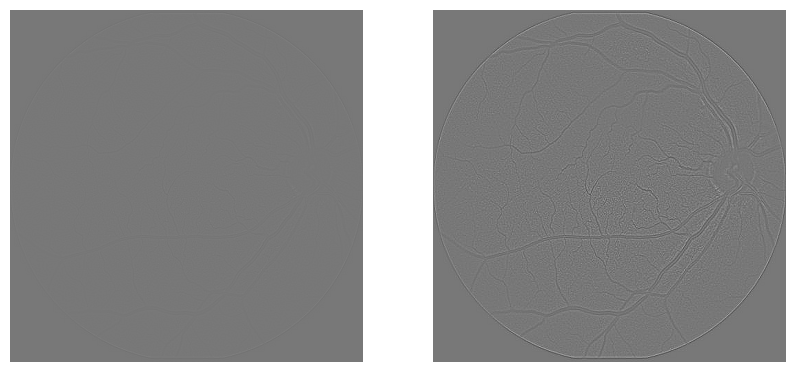

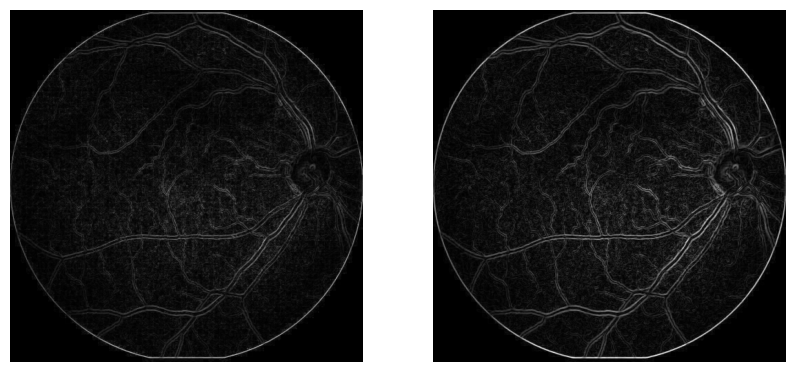

energy of the upscale image: -7.494005416219807e-14
energy of the original image: -5.684341886080802e-14
energy of the upscale image: 49115.56599560854
energy of the original image: 5374.802097885846


In [102]:
img = images[7]
mask = get_mask(img)

h,w = img.shape

img_upscale = transform.resize(img, (h*7, w*7), anti_aliasing=True, order=1)
laplacian_upscale = filters.laplace(img_upscale)
laplacian_origin = filters.laplace(img)

sobel_upscale = filters.sobel(img_upscale)
sobel_origin = filters.sobel(img)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(laplacian_upscale, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(laplacian_origin, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sobel_upscale, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sobel_origin, cmap='gray')
plt.axis('off')
plt.show()



print(f'energy of the upscale image: {np.sum(laplacian_upscale)}')
print(f'energy of the original image: {np.sum(laplacian_origin)}')

print(f'energy of the upscale image: {np.sum(sobel_upscale)}')
print(f'energy of the original image: {np.sum(sobel_origin)}')

# Extraction de charactéristique

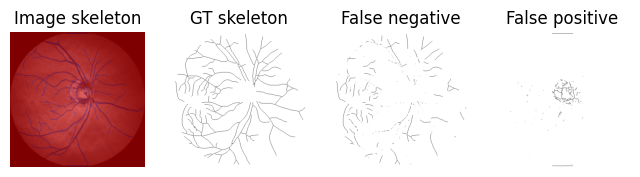

(0.8054773963609079, 0.5993021632937893)

In [122]:
edge = my_segmentation(images[6])
my_evaluate(images[6], edge, images_gt[6])

# Seuillage

(-0.09, 0.09)

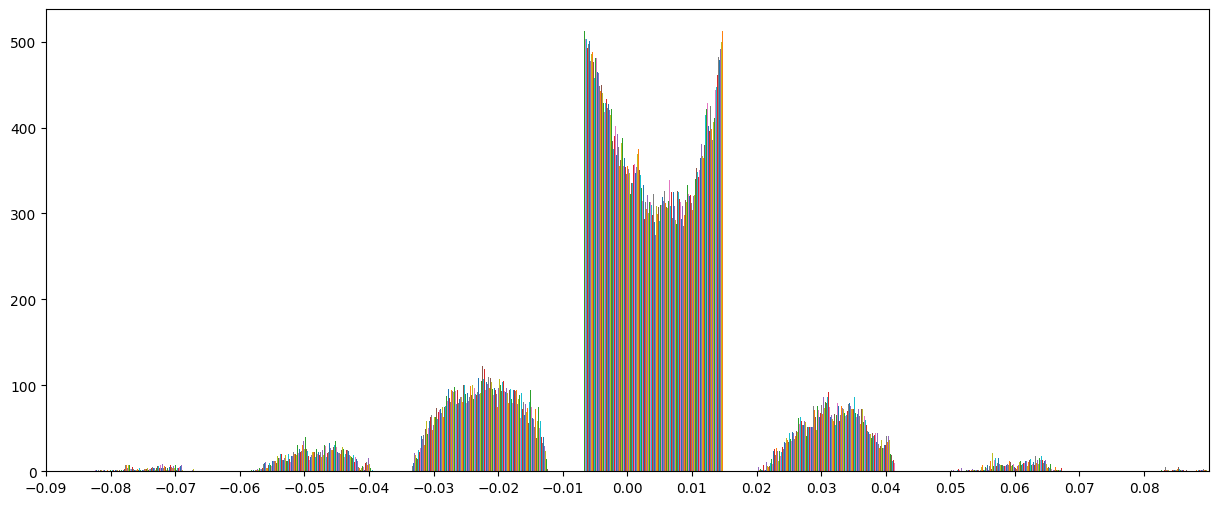

In [104]:
sigma, octave, order, upscale_factor = 2.3, 3, 3, 7

img = images[7]
img = normalize_min_max(img, get_mask(img))
img = transform.resize(img, (h*upscale_factor, w*upscale_factor), anti_aliasing=True, order=order)

pyramid = gaussian_pyramid(img,sigma=sigma, octave=octave, order=order)
laplacian = np.zeros((h*upscale_factor,w*upscale_factor))
for i in range(len(pyramid)):
   laplacian += pyramid[i]['lapl']
l_resized = transform.resize(laplacian, (h, w), anti_aliasing=True, order=order)

plt.figure(figsize=(15,6))
plt.hist(l_resized)
tick_values = np.arange(-0.09, 0.09, 0.01)
plt.xticks(tick_values)
plt.xlim(-0.09, 0.09)

Threshold -0.009311142677734467 0.0011728503535440027


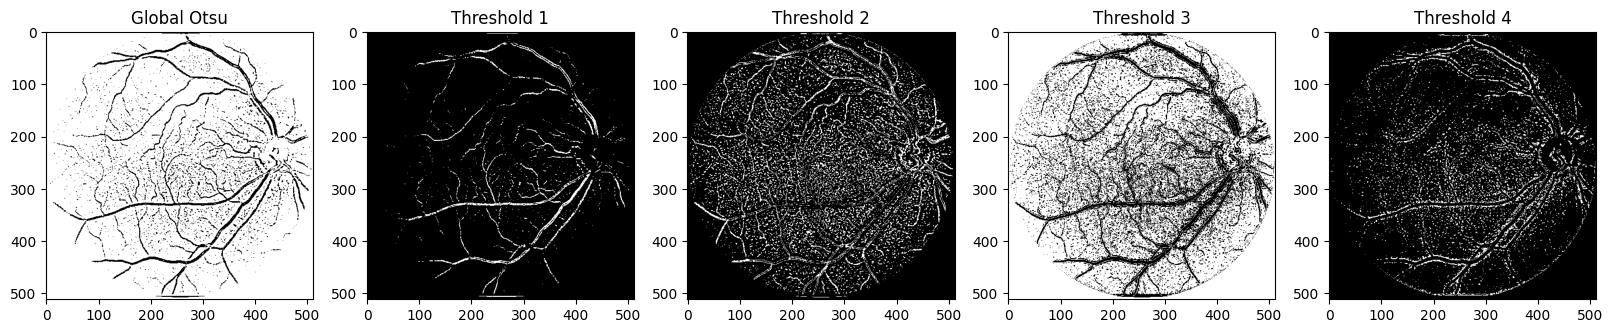

In [105]:
thd = filters.threshold_otsu(l_resized)
th1 = filters.threshold_triangle(l_resized)
print("Threshold", thd, th1)
binary_global = l_resized > 2 * thd

Thds = [-0.035, -0.01, 0.02, 0.05]

plt.figure(figsize=(20, 20))
# Add the global threshold binary image as the first subplot
plt.subplot(1, len(Thds) + 1, 1)
plt.imshow(binary_global, cmap='gray')
plt.title("Global Otsu")

# start=1 to correctly set subplot indices
for idx, threshold in enumerate(Thds, start=1):
    plt.subplot(1, len(Thds) + 1, idx + 1)  # Adjust subplot index
    if idx == 1:
        binary = l_resized < threshold
    else:
        binary = (l_resized > Thds[idx - 2]) & (l_resized <= threshold)
    plt.imshow(binary, cmap='gray')
    plt.title(f"Threshold {idx}")

# Post processing

Cf extraction de characteristique

# Eval

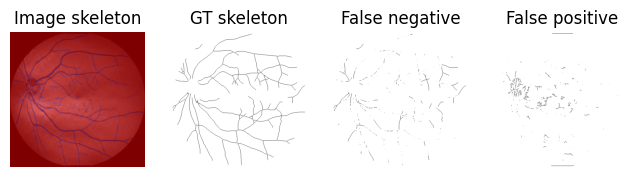

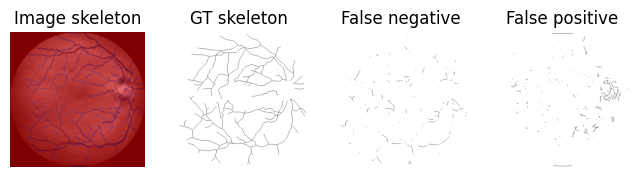

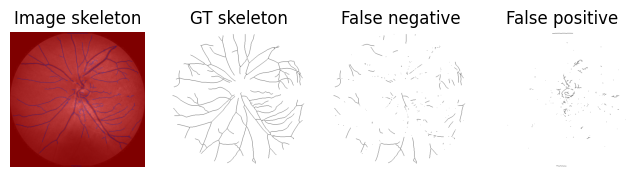

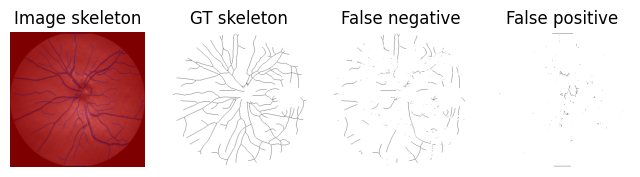

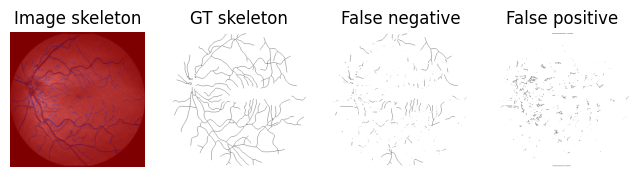

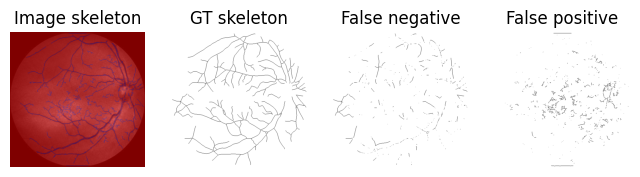

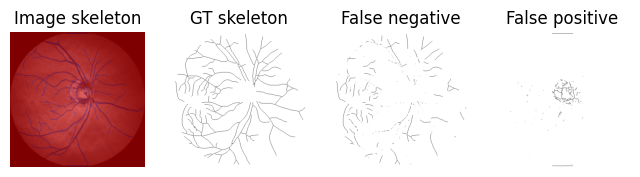

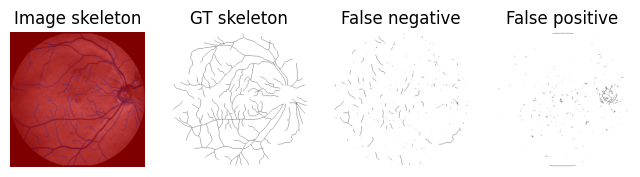

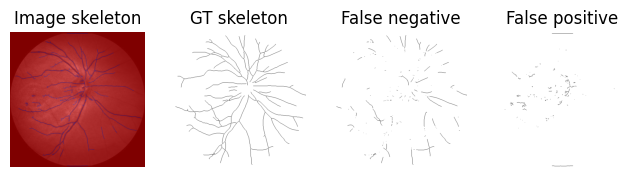

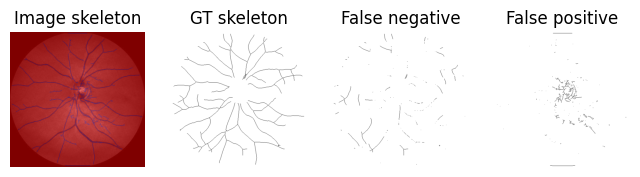

0.7522321428571429 0.7604362542309139
total precision 0.7522321428571429 +/- 0.0
total precision 0.7604362542309139 +/- 0.0


In [123]:
run_eval()